# Exploring SEU Runs


In [245]:
from src import DataReader
from src import InfoEnum

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os
from string import ascii_lowercase

In [246]:
# Load the data
data_path = os.path.join(os.getcwd(), "data")
seu_data, golden_data = DataReader.get_data(data_path)
diff_data = seu_data.copy()

for col in golden_data.index:
    diff = seu_data[col] - golden_data[col]
    diff_data[col] = diff

diff_data = diff_data.drop(columns=["hard error"])
hard_error_runs = seu_data.loc[seu_data["hard error"]].drop(columns=["hard error"])

# Map between easy keys and register names
_key_to_reg = dict()
_reg_to_key = dict()
max_reg_len = 0
for i, unique_register in enumerate(seu_data[InfoEnum.register.name].unique()):
    key = ascii_lowercase[i%len(ascii_lowercase)] + str(i//len(ascii_lowercase))
    max_reg_len = max(max_reg_len, len(unique_register))
    
    _key_to_reg[key] = unique_register
    _reg_to_key[unique_register] = key

key_to_reg = lambda x: _key_to_reg[x]
reg_to_key = lambda x: _reg_to_key[x]

seu_data[InfoEnum.register.name] = seu_data[InfoEnum.register.name].apply(reg_to_key)
diff_data[InfoEnum.register.name] = diff_data[InfoEnum.register.name].apply(reg_to_key)
hard_error_runs[InfoEnum.register.name] = hard_error_runs[InfoEnum.register.name].apply(reg_to_key)

# Print register map
print()
print("Register map:")
s1 = "key name"
s2 = " "
s3 = "register name"
print("    ", end="")
print(s1, s2, s3)
for key, value in _key_to_reg.items():
    _s1 = key
    _s2 = value
    _s1 = _s1 + " "*(len(s1) - len(_s1))
    _s2 = _s2 + " "*(max_reg_len - len(_s2))
    print("    ", end="")
    print(_s1, s2, _s2)

# Useful definition
soft_diffs = [
    InfoEnum.seedcrc.name,
    InfoEnum.listcrc.name,
    InfoEnum.matrixcrc.name,
    InfoEnum.statecrc.name,
    InfoEnum.finalcrc.name,
    InfoEnum.coremark_freq.name,
]

Error reading log file:
method:      <bound method DataReader._read_M_to_int of <class 'src.data_reader.DataReader'>>
line:        CoreMark / MHz: 2.Forcing value for env.ibex_soc_wrap.ibex_soc_wrap.ibex_soc_i.apb_subsystem.i2c_master.i2c_master_core_i.rx_fifo.mem

Info:        InfoEnum.coremark_freq
Log path:    /tools/Ibex-Analysis/data/seu_2023-08-28_14-27-32.653405/log.txt
exception:   list index out of range

Register map:
    key name   register name
    a0         apb_subsystem.htif.cpuif_wr_biten                                                                       
    b0         apb_subsystem.uart.uart_core_i.txfifo.fifo                                                              
    c0         apb_subsystem.i2c_master.i2c_master_core_i.tx_fifo.mem                                                  
    d0         apb_subsystem.i2c_master.i2c_master_core_i.cmd_fifo.mem                                                 
    e0         apb_subsystem.gpio.gpio_core_i.gpio_falling_

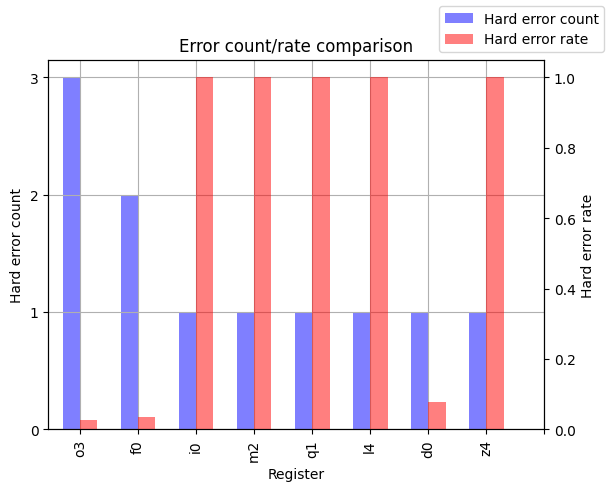

In [247]:
# Here we registers seem to cause hard errors, and what the rate of those errors are
# meaning often does the register cause a hard error
vc = hard_error_runs[InfoEnum.register.name].value_counts()
vc = vc.sort_values(ascending=False)

reg_counts = seu_data[InfoEnum.register.name].value_counts()
vc_norm = vc/reg_counts
vc_norm = vc_norm.dropna()

fig, ax = plt.subplots()
ax_norm = ax.twinx()
vc_norm.plot.bar(
    ax=ax_norm, color="red", alpha=0.5, label="Hard error rate", width=0.3, position=0
)
vc.plot.bar(
    ax=ax, color="blue", alpha=0.5, label="Hard error count", width=0.3, position=1
)
ax.set_ylabel("Hard error count")
ax_norm.set_ylabel("Hard error rate")
ax.set_yticks(list(range(vc.values.max() + 1)), list(range(vc.values.max() + 1)))
ax.set_xticks(list(range(len(vc.values) + 1)))
ax.set_xlabel("Register")
fig.legend(loc="upper right")
ax.set_title("Error count/rate comparison")
ax.grid()
plt.show()

# 1 2 8 9 10 12

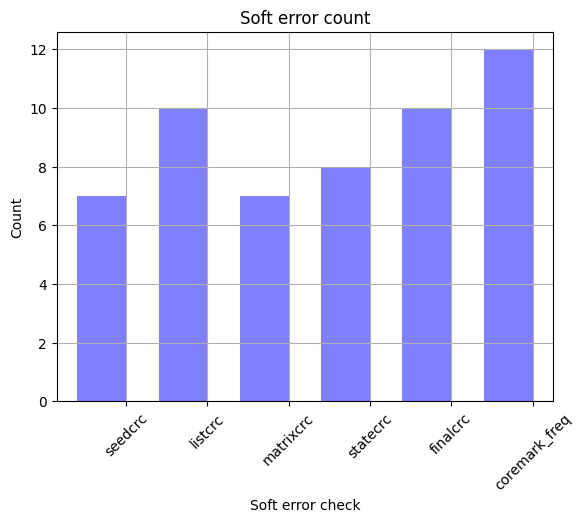

In [248]:
# Check where we most often find soft errors
non_zero_diff_count = (diff_data[soft_diffs] != 0).astype(int).sum(axis=0).dropna()

fig, ax = plt.subplots()
non_zero_diff_count.plot.bar(
    ax=ax, color="blue", alpha=0.5, width=0.6, position=1
)
ax.set_ylabel("Count")
ax.set_xlabel("Soft error check")
ax.set_title("Soft error count")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid()
plt.show()

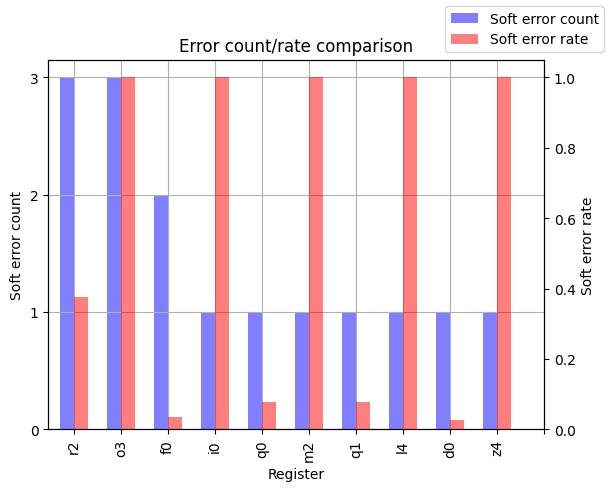

In [249]:
# get the rows diff_data with soft errors (any row with non zero in soft_diffs)
soft_error_runs = diff_data.loc[(diff_data[soft_diffs] != 0).any(axis=1)].copy()
n_soft_e_runs_by_reg = soft_error_runs[InfoEnum.register.name].value_counts()
n_runs_by_reg = seu_data[InfoEnum.register.name].value_counts()
n_runs_by_reg = n_runs_by_reg.loc[n_soft_e_runs_by_reg.index]
n_soft_e_runs_by_reg_norm = n_soft_e_runs_by_reg/n_runs_by_reg

fig, ax = plt.subplots()
ax_norm = ax.twinx()
n_soft_e_runs_by_reg_norm.plot.bar(
    ax=ax_norm, color="red", alpha=0.5, label="Soft error rate", width=0.3, position=0
)
n_soft_e_runs_by_reg.plot.bar(
    ax=ax, color="blue", alpha=0.5, label="Soft error count", width=0.3, position=1
)
ax.set_ylabel("Soft error count")
ax_norm.set_ylabel("Soft error rate")
ax.set_yticks(
    list(range(n_soft_e_runs_by_reg.values.max() + 1)),
    list(range(n_soft_e_runs_by_reg.values.max() + 1))
)
ax.set_xticks(
    list(range(len(n_soft_e_runs_by_reg.values) + 1))
)
ax.set_xlabel("Register")
fig.legend(loc="upper right")
ax.set_title("Error count/rate comparison")
ax.grid()
plt.show()

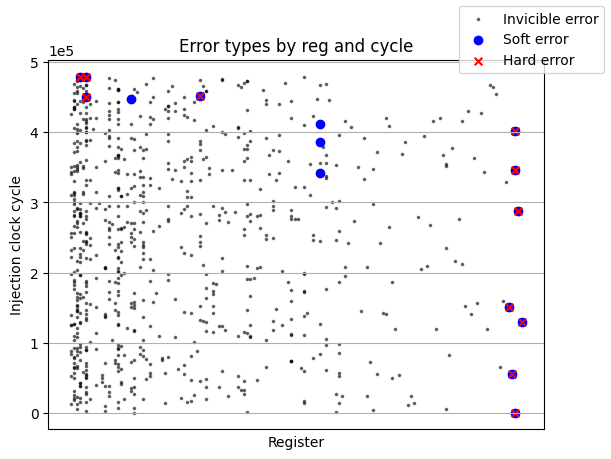

In [301]:
# Show hard/soft/invicible error as a scatter plot, with injection time and register
all_data = seu_data.copy().drop(columns=[
    InfoEnum.value_change_before.name,
    InfoEnum.value_change_after.name,
    InfoEnum.bit_number.name,
])

hard_errors = all_data.loc[all_data["hard error"]].drop(
    columns=soft_diffs + ["hard error"]
)

soft_errors = all_data.loc[(diff_data[soft_diffs] != 0).any(axis=1)].drop(
    columns=["hard error"] + soft_diffs
)

invicible_errors = all_data.drop(
    columns=["hard error"] + soft_diffs
)
invicible_errors = invicible_errors.drop(hard_errors.index, errors="ignore")
invicible_errors = invicible_errors.drop(soft_errors.index, errors="ignore")

fig, ax = plt.subplots()
ax.scatter(
    invicible_errors[InfoEnum.register.name],
    invicible_errors[InfoEnum.injection_clock_cycle.name],
    color="black",
    alpha=0.5,
    label="Invicible error",
    marker=".",
    s=10,
)
ax.scatter(
    soft_errors[InfoEnum.register.name],
    soft_errors[InfoEnum.injection_clock_cycle.name],
    color="blue",
    label="Soft error",
    marker="o",
)
ax.scatter(
    hard_errors[InfoEnum.register.name],
    hard_errors[InfoEnum.injection_clock_cycle.name],
    color="red",
    label="Hard error",
    marker="x",
    s=30,
)
ax.set_xticks([])
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.set_xlabel("Register")
ax.set_ylabel("Injection clock cycle")
ax.set_title("Error types by reg and cycle")
ax.grid()
fig.legend(loc="upper right")
plt.show()